# *Process list of ParOSol outputs*
Voxel-uFE models solved in ParOSol

Created on:  14.11.2025 <br />
Last update: 02.12.2025 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2025
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
## Aims
![](./../../fem_pipeline.png)
This notebook does:
1. Load list of ParOSol `.h5` output files
2. Calculate apparent elastic modulus from reaction forces
---
## Useful commands
### Run FE pipeline (generate models)
```bash
python3 ~/myterminus/code/supertab/scripts/ciclope_voxelFE_pipeline_ParOSol.py
```

### Copy FE dir to `euler`
```bash
scp -r /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250 giiori@euler://cluster/scratch/giiori/tacosound/HR-pQCT_II/parosol/
```

### Copy results from `euler` to `terminus`
```bash
scp giiori@euler://cluster/scratch/giiori/tacosound/HR-pQCT_II/parosol/20251128_122250/* /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/
```

### Generate Paraview `.xmf` output file from ParOSol `.h5`
```bash
python3 ~/myterminus/code/parosol-tu-wien/tools/createxmf.py ./sr_idx1.h5 
```

---
## Configuration and imports

In [1]:
import sys
# sys.path.append('./../../')

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import re

import h5py

from ciclope.utils.postprocess import reaction_forces

/home/giiori/myterminus/code/micromamba/envs/ciclope/lib/python3.11/site-packages/ciclope/utils/postprocess.py:16: RuntimeWarning: ParaView.simple is required!
  warnings.warn("ParaView.simple is required!", RuntimeWarning)


## Load list of files

In [20]:
# data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251105_125728/'
data_path = '~/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/'
file_list = 'parosol_models_pure_QCT.lst'
stats_file = '~/myterminus/code/supertab/stat_outputs/20251128_122250_parosol_models_pure_QCT.csv'

In [6]:
# Read list of filenames from .lst file
lst_file_path = os.path.join(os.path.expanduser(data_path), file_list)

with open(lst_file_path, 'r') as f:
    file_paths = [line.strip() for line in f.readlines()]

# Replace absolute paths with data_path
file_paths = [os.path.join(os.path.expanduser(data_path), os.path.basename(fpath)) for fpath in file_paths]

print(f"Loaded {len(file_paths)} files from {file_list}")
for i, fpath in enumerate(file_paths):
    print(f"  {i+1}: {fpath}")

Loaded 90 files from parosol_models_pure_QCT.lst
  1: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx0_zz.h5
  2: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx0_yy.h5
  3: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx0_xx.h5
  4: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx1_zz.h5
  5: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx1_yy.h5
  6: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx1_xx.h5
  7: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx2_zz.h5
  8: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx2_yy.h5
  9: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx2_xx.h5
  10: /home/giiori/terminus/external/tacosound/HR-pQCT_II/parosol/20251128_122250/hr_idx3_zz.h5


## Post-processing of FE results
### Read ParOSol output and Reaction forces

In [12]:
plane_lock_num = 10
slice_level = plane_lock_num + 1

In [47]:
# Read results for all files and store in DataFrame
results_list = []

for fpath in file_paths:
    try:
        res = reaction_forces(fpath, slice_level)
        base = os.path.basename(fpath)
        # scale is prefix before first underscore (e.g., 'hr', 'sr', 'lr')
        scale = base.split('_')[0]
        # extract numeric index after 'idx'
        m = re.search(r'idx(\d+)', base)
        idx = int(m.group(1)) if m else None

        # extract orientation
        if 'xx' in base:
            orientation = 'xx'
        elif 'yy' in base:
            orientation = 'yy'
        elif 'zz' in base:
            orientation = 'zz'
        else:
            orientation = 'unknown'

        res['file'] = base
        res['idx'] = idx
        res['orientation'] = orientation
        res['scale'] = scale
        res['model'] = Path(base).stem
        results_list.append(res)
    except Exception as e:
        print(f"Error processing {fpath}: {e}")

# Create DataFrame from results
df_results = pd.DataFrame(results_list)

# Normalize types: idx as integer (nullable Int64)
if 'idx' in df_results.columns:
    df_results['idx'] = pd.to_numeric(df_results['idx'], errors='coerce').astype('Int64')

df_results = df_results.rename(columns={'idx': 'patch_idx', 'scale': 'source'})
df_results['source'] = df_results['source'].str.upper()
df_results.set_index('model')

print(f"Created DataFrame with {len(df_results)} rows")
df_results.head()

Created DataFrame with 90 rows


,Z_min,Z_max,total_force,F_tot,num_nodes,num_elements,vs,nodes_z0_count,nodes_z1_count,file,patch_idx,orientation,source,model
0,7.4538,7.7568,"[-33.73400192780929, 51.799633685987004, -215....",224.669167,4132455,2926108,0.0303,63468,101941,hr_idx0_zz.h5,0,zz,HR,hr_idx0_zz
1,7.4538,7.7568,"[2.71758861887048, -9.089463639146036, -17.771...",20.145632,4132455,2926108,0.0303,50614,120662,hr_idx0_yy.h5,0,yy,HR,hr_idx0_yy
2,7.4538,7.7568,"[-33.73400192780929, 51.799633685987004, -215....",224.669167,4132455,2926108,0.0303,63468,101941,hr_idx0_xx.h5,0,xx,HR,hr_idx0_xx
3,7.4538,7.7568,"[1.909618807721094, 45.57330952397998, -120.66...",129.000466,3802049,2542859,0.0303,83138,29020,hr_idx1_zz.h5,1,zz,HR,hr_idx1_zz
4,7.4538,7.7568,"[17.541031078300886, -3.17215867349043, -56.49...",59.237008,3802049,2542859,0.0303,92204,34202,hr_idx1_yy.h5,1,yy,HR,hr_idx1_yy


In [37]:
# Read stats file
stats_path = os.path.expanduser(stats_file)
df_stats = pd.read_csv(stats_path)
df_stats = df_stats.rename(columns={'bone_volume_fraction': 'BVTV'})
df_stats['model'] = None
for i, row in df_stats.iterrows():
    df_stats.at[i, 'model'] = os.path.splitext(os.path.basename(row['model_name']))[0]
# df_stats['model'] = os.path.splitext(os.path.basename(df_stats['model_name']))[0]

df_stats.set_index('model')

print(f"Loaded stats from {stats_file}")
print(f"Shape: {df_stats.shape}")
df_stats.head()

Loaded stats from ~/myterminus/code/supertab/stat_outputs/20251128_122250_parosol_models_pure_QCT.csv
Shape: (90, 7)


,model_name,BVTV,position,patch_idx,orientation,source,model
0,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.176298,"([4096, 4352], [1536, 1792], [2304, 2560])",0,zz,HR,hr_idx0_zz
1,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.176298,"([4096, 4352], [1536, 1792], [2304, 2560])",1,yy,HR,hr_idx0_yy
2,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.176298,"([4096, 4352], [1536, 1792], [2304, 2560])",2,xx,HR,hr_idx0_xx
3,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.152238,"([4352, 4608], [1024, 1280], [2048, 2304])",3,zz,HR,hr_idx1_zz
4,/usr/terminus/data-xrm-01/stamplab/external/ta...,0.152238,"([4352, 4608], [1024, 1280], [2048, 2304])",4,yy,HR,hr_idx1_yy


In [60]:
cols_to_use = df_stats.columns.difference(df_results.columns)

In [65]:
# df_results = pd.merge(df_results, df_stats, on='model', how='inner')
df_results = pd.merge(df_results, df_stats[cols_to_use], left_index=True, right_index=True, how='outer')

In [30]:
df_results[(df_results['source'] == 'SR') & (df_results['orientation'] == 'zz')]['F_tot'].shape

(10,)

In [32]:
df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['F_tot']

0    224.669167
Name: F_tot, dtype: float64

In [68]:
df_results[(df_results['source'] == 'SR') & (df_results['orientation'] == 'zz')]['F_tot']

30    133.916967
33     54.861916
36      2.319320
39    175.499734
42    267.751474
45     70.914015
48     32.990490
51     75.787719
54      3.262014
57      1.219572
Name: F_tot, dtype: float64

In [72]:
df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['F_tot']

0     224.669167
3     129.000466
6      35.756720
9     269.308187
12    354.516283
15    153.434547
18    108.555934
21    152.484408
24     33.228182
27     13.184754
Name: F_tot, dtype: float64

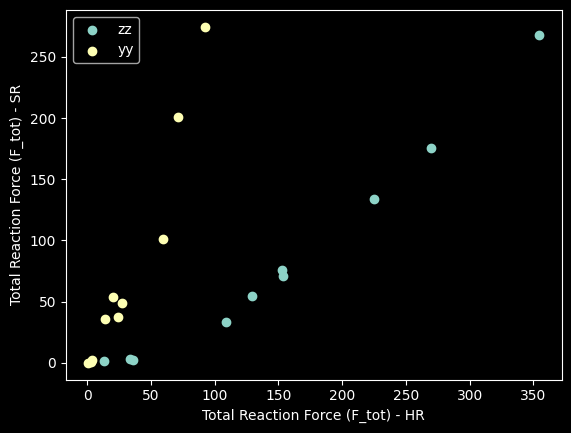

In [73]:
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['F_tot'], df_results[(df_results['source'] == 'SR') & (df_results['orientation'] == 'zz')]['F_tot'], label='zz')
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'yy')]['F_tot'], df_results[(df_results['source'] == 'SR') & (df_results['orientation'] == 'yy')]['F_tot'], label='yy')
# plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'xx')]['F_tot'], df_results[(df_results['source'] == 'SR') & (df_results['orientation'] == 'xx')]['F_tot'], label='xx')

plt.xlabel('Total Reaction Force (F_tot) - HR')
plt.ylabel('Total Reaction Force (F_tot) - SR')
plt.legend(loc='upper left')
# plt.title('F_tot vs Bone Volume Fraction for SR models')

Text(0.5, 1.0, 'ZZ')

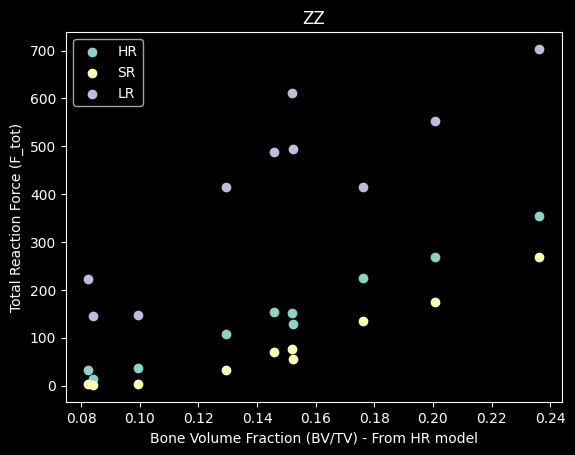

In [78]:
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['BVTV'], df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['F_tot'], label='HR')
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['BVTV'], df_results[(df_results['source'] == 'SR') & (df_results['orientation'] == 'zz')]['F_tot'], label='SR')
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['BVTV'], df_results[(df_results['source'] == 'LR') & (df_results['orientation'] == 'zz')]['F_tot'], label='LR')
plt.xlabel('Bone Volume Fraction (BV/TV) - From HR model')
plt.ylabel('Total Reaction Force (F_tot)')
plt.legend(loc='upper left')
plt.title('ZZ')

Text(0.5, 1.0, 'YY')

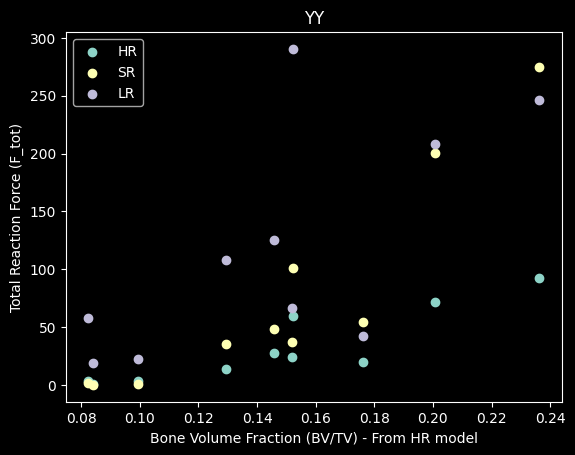

In [79]:
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'yy')]['BVTV'], df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'yy')]['F_tot'], label='HR')
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'yy')]['BVTV'], df_results[(df_results['source'] == 'SR') & (df_results['orientation'] == 'yy')]['F_tot'], label='SR')
plt.scatter(df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'yy')]['BVTV'], df_results[(df_results['source'] == 'LR') & (df_results['orientation'] == 'yy')]['F_tot'], label='LR')
plt.xlabel('Bone Volume Fraction (BV/TV) - From HR model')
plt.ylabel('Total Reaction Force (F_tot)')
plt.legend(loc='upper left')
plt.title('YY')

### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [80]:
voxel_size_mm=0.0303
cube_size = 256
topDisplacement=-0.004 * cube_size * voxel_size_mm

A = (cube_size*voxel_size_mm)**2 # [mm2]
epsilon = np.abs(topDisplacement)/(cube_size*voxel_size_mm)

In [81]:
print(topDisplacement)

-0.0310272


In [87]:
print((df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz')]['F_tot']/A)/epsilon)

0      933.508541
3      536.001617
6      148.570468
9     1118.985289
12    1473.028023
15     637.526111
18     451.053844
21     633.578250
24     138.064301
27      54.783131
Name: F_tot, dtype: float64


In [86]:
df_results[(df_results['source'] == 'HR') & (df_results['orientation'] == 'zz') ]

,Z_min,Z_max,total_force,F_tot,num_nodes,num_elements,vs,nodes_z0_count,nodes_z1_count,file,patch_idx,orientation,source,model,BVTV,model_name,position
0,7.4538,7.7568,"[-33.73400192780929, 51.799633685987004, -215....",224.669167,4132455,2926108,0.0303,63468,101941,hr_idx0_zz.h5,0,zz,HR,hr_idx0_zz,0.176298,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4096, 4352], [1536, 1792], [2304, 2560])"
3,7.4538,7.7568,"[1.909618807721094, 45.57330952397998, -120.66...",129.000466,3802049,2542859,0.0303,83138,29020,hr_idx1_zz.h5,1,zz,HR,hr_idx1_zz,0.152238,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1024, 1280], [2048, 2304])"
6,7.4538,7.7568,"[-3.781825884192806, 12.180458224032302, -33.4...",35.756720,2462559,1598773,0.0303,67703,22407,hr_idx2_zz.h5,2,zz,HR,hr_idx2_zz,0.099210,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1024, 1280], [2304, 2560])"
9,7.4538,7.7568,"[-12.373294858774123, 76.75159588984899, -257....",269.308187,4817231,3359954,0.0303,79684,96712,hr_idx3_zz.h5,3,zz,HR,hr_idx3_zz,0.200799,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1280, 1536], [2048, 2304])"
12,7.4538,7.7568,"[-31.11636806250812, 77.89812164090178, -344.4...",354.516283,5496450,3961461,0.0303,92374,91814,hr_idx4_zz.h5,4,zz,HR,hr_idx4_zz,0.236293,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1280, 1536], [2304, 2560])"
15,7.4538,7.7568,"[-15.114332700349928, 47.39316464277366, -145....",153.434547,3592754,2439841,0.0303,68798,56705,hr_idx5_zz.h5,5,zz,HR,hr_idx5_zz,0.145824,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1280, 1536], [2560, 2816])"
18,7.4538,7.7568,"[-10.155226805507448, 25.122882185188796, -105...",108.555934,3333485,2157538,0.0303,45193,73862,hr_idx6_zz.h5,6,zz,HR,hr_idx6_zz,0.129337,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1536, 1792], [2048, 2304])"
21,7.4538,7.7568,"[-8.312018618582997, 29.972096669377464, -149....",152.484408,3770879,2527697,0.0303,54601,62325,hr_idx7_zz.h5,7,zz,HR,hr_idx7_zz,0.152045,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1536, 1792], [2304, 2560])"
24,7.4538,7.7568,"[-7.346400211865397, 10.734270358113525, -30.5...",33.228182,2142450,1348032,0.0303,33553,38831,hr_idx8_zz.h5,8,zz,HR,hr_idx8_zz,0.082425,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4352, 4608], [1536, 1792], [2560, 2816])"
27,7.4538,7.7568,"[1.4622288589332448, -2.5784881813899236, -12....",13.184754,2174448,1354110,0.0303,24410,36568,hr_idx9_zz.h5,9,zz,HR,hr_idx9_zz,0.083863,/usr/terminus/data-xrm-01/stamplab/external/ta...,"([4608, 4864], [768, 1024], [2304, 2560])"
